In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import random
import numpy as np
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import timm

In [2]:
dataset_path = "/kaggle/input/ucmerced/UCMercedDatasetOriginal/Images"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

train_idx, test_idx = train_test_split(
    range(len(full_dataset)), test_size=0.2, random_state=42,
    stratify=[label for _, label in full_dataset.samples]
)

train_set = Subset(full_dataset, train_idx)
test_set = Subset(full_dataset, test_idx)

batch_size = 32
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print(f"Total samples: {len(full_dataset)}")
print(f"Train set size: {len(train_set)}")
print(f"Test set size: {len(test_set)}")


Total samples: 2100
Train set size: 1680
Test set size: 420


In [3]:
def add_label_noise(dataset, noise_level=0.3):
    dataset_noisy = copy.deepcopy(dataset)
    num_samples = len(dataset_noisy.dataset.samples)
    num_noisy = int(noise_level * num_samples)

    indices = random.sample(range(num_samples), num_noisy)
    class_count = len(dataset_noisy.dataset.classes)

    for idx in indices:
        _, old_label = dataset_noisy.dataset.samples[idx]
        new_label = random.randint(0, class_count - 1)
        while new_label == old_label:
            new_label = random.randint(0, class_count - 1)
        dataset_noisy.dataset.samples[idx] = (dataset_noisy.dataset.samples[idx][0], new_label)

    return dataset_noisy


In [4]:
class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=21):
        super(EfficientNetB0, self).__init__()
        self.encoder = timm.create_model("efficientnet_b0", pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.encoder(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    test_acc = 100 * correct / total
    print(f"\nTest Accuracy: {test_acc:.2f}%\n")
    return test_acc


In [5]:
def train_model(model, train_loader, test_loader, epochs=5):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05)

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {total_loss:.4f} - Train Accuracy: {train_acc:.2f}%")

    return test_model(model, test_loader)


In [7]:
noise_levels = [30, 40, 50, 60, 80]
accuracies = []

for noise in noise_levels:
    print(f"\nTraining EfficientNet-B0 with {noise}% label noise...\n")  
    train_set_noisy = add_label_noise(train_set, noise_level=noise/100)
    train_loader_noisy = DataLoader(train_set_noisy, batch_size=batch_size, shuffle=True)
    model = EfficientNetB0(num_classes=len(full_dataset.classes))
    acc = train_model(model, train_loader_noisy, test_loader, epochs=5)
    accuracies.append(acc)

for noise, acc in zip(noise_levels, accuracies):
    print(f"Noise Level: {noise}% - Test Accuracy: {acc:.2f}%")



Training EfficientNet-B0 with 30% label noise...



model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch [1/5] - Loss: 140.5447 - Train Accuracy: 39.40%
Epoch [2/5] - Loss: 74.0976 - Train Accuracy: 65.18%
Epoch [3/5] - Loss: 42.9878 - Train Accuracy: 77.98%
Epoch [4/5] - Loss: 23.8700 - Train Accuracy: 87.62%
Epoch [5/5] - Loss: 12.6453 - Train Accuracy: 93.45%

Test Accuracy: 71.90%


Training EfficientNet-B0 with 40% label noise...

Epoch [1/5] - Loss: 155.1950 - Train Accuracy: 32.14%
Epoch [2/5] - Loss: 84.2883 - Train Accuracy: 57.98%
Epoch [3/5] - Loss: 46.9872 - Train Accuracy: 74.58%
Epoch [4/5] - Loss: 30.0534 - Train Accuracy: 83.81%
Epoch [5/5] - Loss: 17.4212 - Train Accuracy: 91.37%

Test Accuracy: 66.19%


Training EfficientNet-B0 with 50% label noise...

Epoch [1/5] - Loss: 164.6989 - Train Accuracy: 24.82%
Epoch [2/5] - Loss: 95.7123 - Train Accuracy: 51.67%
Epoch [3/5] - Loss: 52.5925 - Train Accuracy: 71.61%
Epoch [4/5] - Loss: 27.5572 - Train Accuracy: 85.18%
Epoch [5/5] - Loss: 16.4183 - Train Accuracy: 91.61%

Test Accuracy: 56.67%


Training EfficientNet-B0 wi

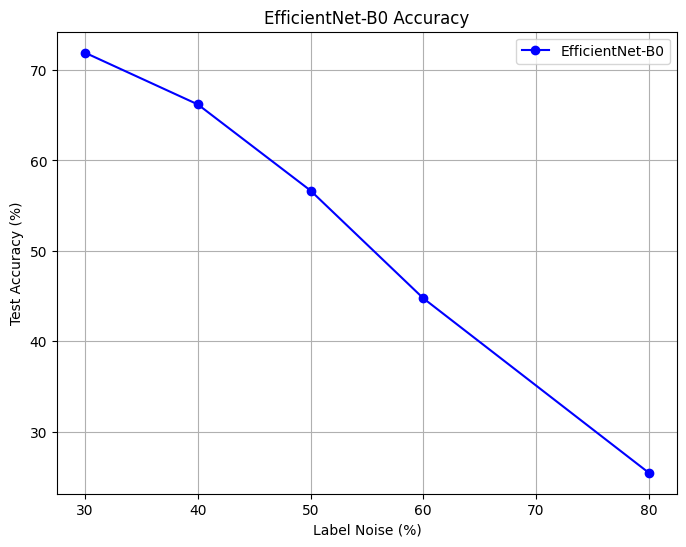

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(noise_levels, accuracies, marker='o', linestyle='-', color='b', label="EfficientNet-B0")
plt.xlabel("Label Noise (%)")
plt.ylabel("Test Accuracy (%)")
plt.title("EfficientNet-B0 Accuracy")
plt.legend()
plt.grid(True)
plt.show()